## <center><font color="brown">ANALISIS SENTIMEN 'BBM'</font></center>

## 1. Data Collecting

Collecting data pada media sosial twitter menggunakan Library <a href="https://www.freecodecamp.org/news/python-web-scraping-tutorial/" target="_blank"><strong>snscrape</strong></a>.


In [1]:
!pip3 install snscrape

In [2]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
import csv
import os, re, string, pickle
import numpy as np
#import matplotlib.pyplot as plt
#import seaborn as sns

Collecting data twitter tentang "BBM" dengan batas total 3000 data.

In [3]:
# Creating list to append tweet data to
tweets_list2 = []

# Using TwitterSearchScraper to scrape data and append tweets to list
for i,tweet in enumerate(sntwitter.TwitterSearchScraper('BBM lang:id since:2022-09-15 until:2022-10-15').get_items()):
    if i>3000:
        break
    tweets_list2.append([tweet.date, tweet.id, tweet.content, tweet.user.username, tweet.likeCount, tweet.retweetCount, tweet.user.location])
    
# Creating a dataframe from the tweets list above
TweetBBM = pd.DataFrame(tweets_list2, columns=['Datetime', 'Tweet Id', 'Tweet', 'Username', 'Total Favorite', 'Total Retweet', 'Lokasi'])

### Data Understanding
Fungsi Pandas `.info()` digunakan untuk mendapatkan ringkasan singkat dari sebuah data frame. Fungsi `.info()` sangat berguna saat melakukan analisis eksplorasi data. 

In [4]:
TweetBBM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3001 entries, 0 to 3000
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   Datetime        3001 non-null   datetime64[ns, UTC]
 1   Tweet Id        3001 non-null   int64              
 2   Tweet           3001 non-null   object             
 3   Username        3001 non-null   object             
 4   Total Favorite  3001 non-null   int64              
 5   Total Retweet   3001 non-null   int64              
 6   Lokasi          3001 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(3), object(3)
memory usage: 164.2+ KB


Didapatkan hasil ringkasan sebagai berikut:
* Terdapat 7 kolom dalam dataframe. 
* <a href="https://belajarpython.com/tutorial/tipe-data-python" target="_blank"><strong>Tipe data</strong></a> dari kolom: satu kolom bertipe data **datetime**, 3 kolom bertipe data **integer**, dan 3 kolom bertipe data **object**.
* Tidak terdapat <a href="https://www.dqlab.id/digital-transformation-pahami-teknik-pengolahan-ini-dalam-industri-data" target="_blank"><strong>missing value</strong></a> , karena setiap kolom memiliki jumlah 3001 baris.


### Hasil Data Collecting
Fungsi `sample()` menampilkan <a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html?highlight=sample#pandas.DataFrame.sample" target="_blank"><strong>sampel</strong></a> acak dari dataframe.

In [6]:
TweetBBM.sample(n=5)

,Datetime,Tweet Id,Tweet,Username,Total Favorite,Total Retweet,Lokasi
1363,2022-10-14 10:27:51+00:00,1580867979142909952,Sudah jelas banget nih BPH Migas Tegaskan Kual...,ztstrw,0,0,
1639,2022-10-14 09:37:22+00:00,1580855273903689728,"CARI BISNIS YG TEPAT,bisnis HWI selalu masuk m...",erfi_fatmawati,0,0,"Purbalingga, Indonesia"
2362,2022-10-14 07:51:40+00:00,1580828672130310144,"Dukung pengalihan subsidi BBM, pengalihan subs...",PuspasariiDewi,0,0,
1449,2022-10-14 10:12:33+00:00,1580864126620160000,@Wiznu_Prayoga kalok cm ngomong itu enak yakkk...,LekMarteg,0,0,"Sukoharjo, Indonesia"
2935,2022-10-14 07:08:44+00:00,1580817866601172994,Di indonesia BBM nya paling murah lo ges.\n\n#...,givqes,0,0,"Medan Polonia, Indonesia"


### Menyimpan Hasil Data Collecting
Hasil Data Collecting disimpan dalam format CSV menggunakan fungsi `.to_csv`.

In [7]:
# Export Data Kumpulan Tweet Ke File CSV
TweetBBM.to_csv('TweetBBM.csv', sep=',', index=False)

### Menghapus Kolom
Menghapus kolom pada dataframe menggunakan fungsi `.drop`.

In [8]:
TweetBBM.drop(['Tweet Id', 'Total Favorite', 'Total Retweet', 'Username', 'Lokasi', 'Datetime'], axis=1, inplace=True)


## 2. Data Preprocessing

Tahapan Data Preprocessing meliputi:

- Normalization: Normalization digunakan untuk menyeragamkan term yang memiliki makna sama namun penulisanya berbeda, bisa diakibatkan kesalahan penulisan, penyingkatan kata, ataupun “bahasa gaul”.
- Cleaning text dan lowercase: Membersihkan teks dari punctuation, URL, ekstra space, dan merubah huruf menjadi huruf kecil. Pada proses cleaning teks mengunakan modul `re`. Regular expression (regex) digunakan untuk menghapus karakter angka. 
- Tokenization: Memisahkan kalimat atau data menjadi potongan-potongan kata dengan kelas. Pada proses tokenize menggunakan fungsi `word_tokenize()` dari library `NLTK`.
- Filtering (Stopword Removal): Menghapus kata yang tidak memiliki makna atau arti ketika berdiri sendiri. Pada proses membuang stopwords dari teks menggunakan fungsi `stopwords` dari library `NLTK`.
- Stemming: Menghapus imbuhan pada tiap kata dan mengubah tiap kata menjadi kata dasar. Pada proses stemming bahasa indonesia dapat menggunakan library `Sastrawi`.
 

In [9]:
!pip install Sastrawi

In [10]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
#from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud

In [11]:
df_Normalization = pd.read_csv('twitter_dict.csv')

In [12]:
def Normalization(tweet):
    tweet = tweet.lower()
    res = ''
    for item in tweet.split():
        if item in df_Normalization.slang.values:
            res += df_Normalization[df_Normalization['slang'] == item]['formal'].iloc[0]
        else:
            res += item
        res += ' '
    return res

In [13]:
def emoji(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :') , :O
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\)|:O)', ' positiveemoji ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' positiveemoji ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' positiveemoji ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-; , @-)
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;|@-\))', ' positiveemoji ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:, :-/ , :-|
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:|:-/|:-\|)', ' negetiveemoji ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' negetiveemoji ', tweet)
    return tweet

In [14]:
def Cleaning(tweet):  
    tweet = re.sub('@[^\s]+', '', tweet)                              # Removes usernames
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', tweet)   # Remove URLs
    tweet = re.sub(r"\d+", " ", str(tweet))                           # Removes all digits
    tweet = re.sub('&quot;'," ", tweet)                               # Remove (&quot;) 
    tweet = emoji(tweet)                                              # Replaces Emojis
    tweet = re.sub(r"\b[a-zA-Z]\b", "", str(tweet))                   # Removes all single characters  
    tweet = re.sub(r'(.)\1+', r'\1\1', tweet)                         # Convert more than 2 letter repetitions to 2 letter
    tweet = re.sub(r"\s+", " ", str(tweet))                           # Replaces double spaces with single space    
    
    tweet = re.sub(r'@[A-Za-z0-9]+', '', tweet)                       # remove mentions
    tweet = re.sub(r'#[A-Za-z0-9]+', '', tweet)                       # remove hashtag
    tweet = re.sub(r'RT[\s]', '', tweet)                              # remove RT
    tweet = re.sub(r"http\S+", '', tweet)                             # remove link
    tweet = re.sub(r'[0-9]+', '', tweet)                              # remove numbers

    tweet = tweet.replace('\n', ' ')                                  # replace new line into space
    tweet = tweet.translate(str.maketrans('', '', string.punctuation)) # remove all punctuations
    tweet = tweet.strip(' ')                                          # remove characters space from both left and right text
    return tweet

def tokenizingText(text): # Tokenizing or splitting a string, text into a list of tokens
    text = word_tokenize(text) 
    return text

def filteringText(text): # Remove stopwors in a text
    listStopwords = set(stopwords.words('indonesian'))
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered 
    return text

def stemmingText(text): # Reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    text = [stemmer.stem(word) for word in text]
    return text

def toSentence(list_words): # Convert list of words into sentence
    sentence = ' '.join(word for word in list_words)
    return sentence

In [15]:
TweetBBM['Tweet_Processed'] = TweetBBM['Tweet'].apply(Normalization)
TweetBBM['Tweet_Processed'] = TweetBBM['Tweet_Processed'].apply(Cleaning)

TweetBBM['text_preprocessed'] = TweetBBM['Tweet_Processed'].apply(tokenizingText)
TweetBBM['text_preprocessed'] = TweetBBM['text_preprocessed'].apply(filteringText)
TweetBBM['text_preprocessed'] = TweetBBM['text_preprocessed'].apply(stemmingText)

# drop duplicates/spams tweets
TweetBBM.drop_duplicates(subset = 'Tweet_Processed', inplace = True)

### Menampilkan hasil data prepocessing
Fungsi `head()` digunakan untuk menampilkan data awal atau data teratas pada dataframe. 

In [16]:
TweetBBM.head(10)

,Tweet,Tweet_Processed,text_preprocessed
0,tp bernbohong urusan serius : 5.00 esemka sd i...,tapi bernbohong urusan serius esemka sd inde...,"[bernbohong, urus, serius, esemka, sd, inden, ..."
1,Jual case iphone unik dan lucu. Chek fav untuk...,jual case iphone unik dan lucu chek favorit un...,"[jual, case, iphone, unik, lucu, chek, favorit..."
2,Harusnya PT Pertamiana dlm menyalurkan BBM Sub...,harusnya pt pertamiana dalam menyalurkan bbm s...,"[pt, pertamiana, salur, bbm, subsidi, bikin, r..."
3,Keberuntungan adalah pertemuan antara persiapa...,keberuntungan adalah pertemuan antara persiapa...,"[untung, temu, siap, sempat, anthony, robbinso..."
4,butuh testimoni?? dengan senang hati kami beri...,butuh testimoni dengan senang hati kami beri b...,"[butuh, testimoni, senang, hati, bukti, via, bbm]"
5,Konrad8899 Mau tampil keren dgn style anime ka...,konrad mau tampil keren dengan style anime kam...,"[konrad, tampil, keren, style, anime, follow, ..."
6,Kalopun leslar berdamai bagi aku harga BBM mas...,kalopun leslar berdamai bagi saya harga bbm ma...,"[kalo, leslar, damai, harga, bbm, mahal, ngaru..."
7,@igoen_anindya @Bangheri_ Kmrn2 lbh seru. Bawa...,kmrn lebih seru bawa mbl di kalan kecil di dep...,"[kmrn, seru, bawa, mbl, kalan, motor, habis, b..."
8,#DISCOUNT 35% |\nRP. 245.000 --&gt; RP. 159.25...,rp gt rp viera basic wa bbm,"[rp, gt, rp, viera, basic, wa, bbm]"
9,Ginseng kianpi pil efektip untuk menambah bera...,ginseng kianpi pil efektip untuk menambah bera...,"[ginseng, kianpi, pil, efektip, tambah, berat,..."


### Frequency Distributions
Untuk mengetahui berapa kali setiap kata muncul dalam teks tertentu menggunakan fungsi `FreqDist` dari library `NLTK`.

In [17]:
from nltk.probability import FreqDist

In [18]:
all_words = [word for item in list(TweetBBM['text_preprocessed']) for word in item]

#distribusi frekuensi dari kata-kata
fdist = FreqDist(all_words)

#banyaknya kata unik
len(fdist)

4578

In [19]:
#mengubah distribusi frekuensi ke dalam dataframe
fdist = pd.DataFrame.from_dict(fdist, orient='index').reset_index()
fdist.columns = ['word', 'freq']
fdist = fdist.sort_values('freq', ascending=False)

In [20]:
#membuang kata dengan <= 1 karakter
fdist = fdist[fdist.apply(lambda r: len(r['word']) > 1, axis=1)]

#membuang angka
fdist = fdist[fdist.apply(lambda r: r['word'].isdigit() == False, axis=1)]

#memilih kata yang muncul >= 10 kali dan <= 2000 kali
fdist = fdist[(fdist.freq >= 10) & (fdist.freq <= 2000)]

In [21]:
fdist.head(10)

,word,freq
118,blt,666
67,harga,545
763,masyarakat,437
23,subsidi,400
491,sesuai,347
483,perintah,251
503,dukung,236
22,salur,208
124,bantu,206
585,barat,190


In [22]:
# Export Data Kumpulan Tweet Ke File CSV
fdist.to_csv('fdist_TweetBBM.csv', sep=',', index=True)

In [23]:
fdist1 = pd.read_csv('fdist_TweetBBM.csv').iloc[:,1:]
fdist1.head(10)

,word,freq
0,blt,666
1,harga,545
2,masyarakat,437
3,subsidi,400
4,sesuai,347
5,perintah,251
6,dukung,236
7,salur,208
8,bantu,206
9,barat,190


### Word Cloud
Word Cloud adalah teknik visualisasi data yang digunakan untuk merepresentasikan data teks di mana ukuran setiap kata menunjukkan frekuensi.

In [24]:
!pip install wordcloud
!pip install stylecloud

In [28]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image

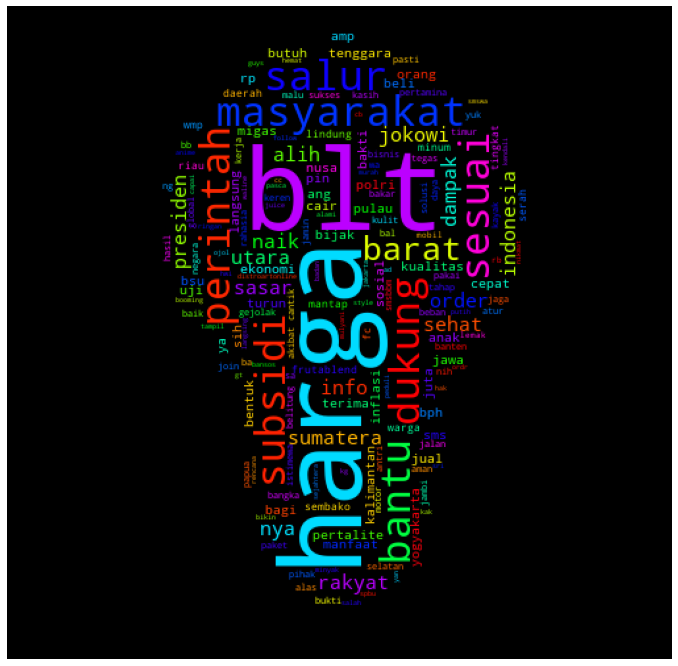

In [29]:
mask = np.array(Image.open('bulb.jpg'))
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1,
                      background_color='black', colormap='gist_rainbow_r', 
                      collocations=False, mask=mask).generate(' '.join(fdist1['word']))
plt.figure(figsize=(15, 12))
plt.imshow(wordcloud) 
plt.axis("off");
plt.savefig('cloud_design.jpg', format=None) #saves word cloud as image

#### Determine sentiment polarity of tweets using indonesia sentiment lexicon (source : https://github.com/fajri91/InSet)

In [30]:
# Loads lexicon positive and negative data
lexicon_positive = dict()
import csv
with open('lexicon_positive.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        lexicon_positive[row[0]] = int(row[1])

lexicon_negative = dict()
import csv
with open('lexicon_negative.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])
        
# Function to determine sentiment polarity of tweets        
def sentiment_analysis_lexicon_indonesia(text):
    #for word in text:
    score = 0
    for word in text:
        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
    for word in text:
        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
    polarity=''
    if (score > 0):
        polarity = 'positive'
    elif (score < 0):
        polarity = 'negative'
    else:
        polarity = 'neutral'
    return score, polarity

In [31]:
#Results from determine sentiment polarity of tweets

results = TweetBBM['text_preprocessed'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
TweetBBM['polarity_score'] = results[0]
TweetBBM['polarity'] = results[1]
print(TweetBBM['polarity'].value_counts())

positive    1263
negative     839
neutral      340
Name: polarity, dtype: int64


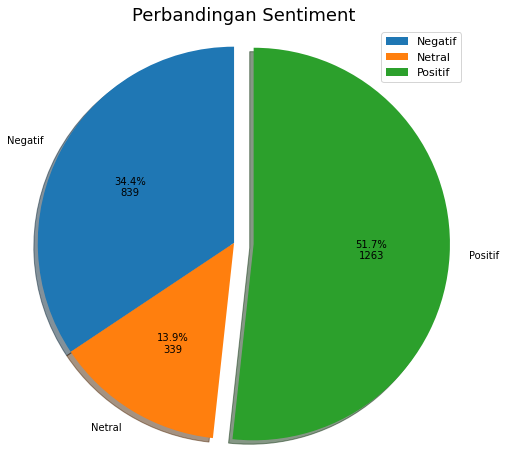

In [32]:
# Plotting Pie
def pct_pie(pct, allvals):
    absolute = int(pct / 100.0 * np.sum(allvals))
    return "{:.1f}%\n{:d}".format(pct, absolute)


sentimen = TweetBBM["text_preprocessed"].groupby(TweetBBM["polarity"]).count().values

plt.figure(figsize=(8, 8))
plt.pie(
    sentimen,
    explode=(0, 0, 0.1),
    labels=["Negatif", "Netral", "Positif"],
    shadow=True,
    autopct=lambda pct: pct_pie(pct, sentimen),
    startangle=90,
)
plt.title("Perbandingan Sentiment", fontsize=18)
plt.axis("equal")
plt.legend(fontsize=11)
plt.show()

In [33]:
TweetBBM.head(10)

,Tweet,Tweet_Processed,text_preprocessed,polarity_score,polarity
0,tp bernbohong urusan serius : 5.00 esemka sd i...,tapi bernbohong urusan serius esemka sd inde...,"[bernbohong, urus, serius, esemka, sd, inden, ...",-4,negative
1,Jual case iphone unik dan lucu. Chek fav untuk...,jual case iphone unik dan lucu chek favorit un...,"[jual, case, iphone, unik, lucu, chek, favorit...",1,positive
2,Harusnya PT Pertamiana dlm menyalurkan BBM Sub...,harusnya pt pertamiana dalam menyalurkan bbm s...,"[pt, pertamiana, salur, bbm, subsidi, bikin, r...",-3,negative
3,Keberuntungan adalah pertemuan antara persiapa...,keberuntungan adalah pertemuan antara persiapa...,"[untung, temu, siap, sempat, anthony, robbinso...",5,positive
4,butuh testimoni?? dengan senang hati kami beri...,butuh testimoni dengan senang hati kami beri b...,"[butuh, testimoni, senang, hati, bukti, via, bbm]",-4,negative
5,Konrad8899 Mau tampil keren dgn style anime ka...,konrad mau tampil keren dengan style anime kam...,"[konrad, tampil, keren, style, anime, follow, ...",-2,negative
6,Kalopun leslar berdamai bagi aku harga BBM mas...,kalopun leslar berdamai bagi saya harga bbm ma...,"[kalo, leslar, damai, harga, bbm, mahal, ngaru...",4,positive
7,@igoen_anindya @Bangheri_ Kmrn2 lbh seru. Bawa...,kmrn lebih seru bawa mbl di kalan kecil di dep...,"[kmrn, seru, bawa, mbl, kalan, motor, habis, b...",-12,negative
8,#DISCOUNT 35% |\nRP. 245.000 --&gt; RP. 159.25...,rp gt rp viera basic wa bbm,"[rp, gt, rp, viera, basic, wa, bbm]",0,neutral
9,Ginseng kianpi pil efektip untuk menambah bera...,ginseng kianpi pil efektip untuk menambah bera...,"[ginseng, kianpi, pil, efektip, tambah, berat,...",0,neutral


In [38]:
# Export Data Kumpulan Tweet Ke File CSV
TweetBBM.to_csv('DP_TweetSubsidiBBM.csv', sep=',', index=False)

In [39]:
data = pd.read_csv('DP_TweetSubsidiBBM.csv')

In [36]:
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import flair
from sklearn.metrics import classification_report, roc_auc_score

In [40]:
data['textblob_polarity'] = data['text_preprocessed'].apply(lambda x: TextBlob(x).sentiment.polarity)
data['textblob_sentiment'] = data['textblob_polarity'].apply(lambda x: "positive" if x > 0.05 else "negative" if x < 0.05 else "neutral")

In [42]:
analyzer = SentimentIntensityAnalyzer()
data['vader_polarity'] = data['text_preprocessed'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
data['vader_sentiment'] = data['vader_polarity'].apply(lambda x: "positive" if x > 0.05 else "negative" if x < 0.05 else "neutral")

In [43]:
data1 = data[['polarity', 'textblob_sentiment', 'vader_sentiment']]
data1

,polarity,textblob_sentiment,vader_sentiment
0,negative,negative,negative
1,positive,negative,negative
2,negative,negative,negative
3,positive,negative,negative
4,negative,negative,negative
...,...,...,...
2437,positive,negative,negative
2438,positive,negative,negative
2439,positive,negative,negative
2440,negative,negative,negative
